# 本筆記的目的：預測重症病患未來的生還率。

[PhysioNet 2012](https://physionet.org/challenge/2012/) 資料集紀錄了各個病患，於離開加護病房後是否有生還。

並且，這些病人，從進入加護病房，至離開，會有各式各樣的生理資訊，於各個時間點被記錄下來。

我們的目的是以這個資料集來建立模型，去讓機器預測一個重症病患進入加護病房後，未來可能會有多少的生還率。

---

In [42]:
# =========================================================================
# 由於課堂上可能有多人共用同一顆GPU，以下限定使用者只能用計算卡上45%的記憶體。
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.95 # 使用45%記憶體
set_session(tf.Session(config=config))
# =========================================================================

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import os
from IPython.display import display
import re

import seaborn as sns
sns.set()

## 1. 載入 & 整理資料

In [44]:
!ls ../datasets/physioNet-set-a | head -n 5

132539.txt
132540.txt
132541.txt
132543.txt
132545.txt


In [45]:
def icu_df_creator(path,verbose=True):
    '''由txt檔載入病人資訊，存成資料表。'''
    df=pd.read_csv(path)
    if verbose:
        print("Before pivot transform:")
        display( df.head(5) )
        print(df.shape)

    encounter_id=re.findall(".*/(.*).txt",path)[0]

    df["encounter_ID"]=int(encounter_id)
    df=df.pivot_table(index=["encounter_ID","Time"],
                      columns="Parameter",
                      values="Value")
    df.columns.name=""
    df = df.astype(np.float32)
    df.drop(columns="RecordID",inplace=True)
    if verbose:
        print("\nAfter pivot transform:")
        display( df.head(5) )
        print(df.shape)
    return df

---

In [46]:
def filePathsGen(rootPath):
    '''此函數將rootPath資料夾目錄中的所有檔案路徑資訊儲存至一個清單內。'''
    paths=[]
    dirs=[]
    for dirPath,dirNames,fileNames in os.walk(rootPath):
        for fileName in fileNames:
            fullPath=os.path.join(dirPath,fileName)
            paths.append( fullPath) 
        dirs.append(dirNames)
    return dirs,paths

In [47]:
root_folder="../datasets/physioNet-set-a"
_,paths = filePathsGen(root_folder)

dfs=[]
for idx,path in enumerate(paths):
    if idx%200==0:
        print(idx,path)
    if "Outcomes-a" in path:
        continue
    dfs.append( icu_df_creator(path,verbose=False) 
              )

0 ../datasets/physioNet-set-a/137602.txt
200 ../datasets/physioNet-set-a/139444.txt
400 ../datasets/physioNet-set-a/134097.txt
600 ../datasets/physioNet-set-a/137973.txt
800 ../datasets/physioNet-set-a/142664.txt
1000 ../datasets/physioNet-set-a/138621.txt
1200 ../datasets/physioNet-set-a/139001.txt
1400 ../datasets/physioNet-set-a/142475.txt
1600 ../datasets/physioNet-set-a/135051.txt
1800 ../datasets/physioNet-set-a/138745.txt
2000 ../datasets/physioNet-set-a/138955.txt
2200 ../datasets/physioNet-set-a/135146.txt
2400 ../datasets/physioNet-set-a/136777.txt
2600 ../datasets/physioNet-set-a/138493.txt
2800 ../datasets/physioNet-set-a/140874.txt
3000 ../datasets/physioNet-set-a/141236.txt
3200 ../datasets/physioNet-set-a/132832.txt
3400 ../datasets/physioNet-set-a/137450.txt
3600 ../datasets/physioNet-set-a/132540.txt
3800 ../datasets/physioNet-set-a/133059.txt
4000 ../datasets/physioNet-set-a/133487.txt


In [48]:
df = pd.concat(dfs)

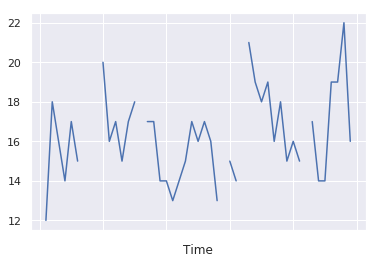

In [49]:
df.head(5)
df.loc[133487].RespRate.plot()

#### 整理出存放特徵欄位的Tensor，分別為train_x, val_x和test_x。

In [65]:
icu_data_y

RecordID
132539    0
132540    0
132541    0
132543    0
132545    0
132547    0
132548    0
132551    1
132554    0
132555    0
132556    0
132567    0
132568    0
132570    0
132573    0
132575    0
132577    0
132582    0
132584    0
132585    0
132588    1
132590    0
132591    0
132592    0
132595    0
132597    0
132598    1
132599    0
132601    0
132602    1
         ..
142591    0
142595    0
142601    0
142603    1
142607    0
142609    0
142612    0
142618    1
142621    0
142626    1
142634    0
142635    0
142637    0
142638    1
142640    0
142641    0
142646    0
142649    0
142653    0
142654    0
142655    0
142659    0
142661    0
142662    0
142664    0
142665    0
142667    0
142670    0
142671    1
142673    0
Name: In-hospital_death, Length: 4000, dtype: int64

In [50]:
# 資料切成 70% train, 15% validation, 15% test

pids = pd.Series( df.index.levels[0] )
pids_train_x = pids.sample(frac=0.7)
pids_test_x = pids.drop(index=pids_train_x.index)
pids_val_x = pids_test_x.sample(frac=0.5)
pids_test_x = pids_test_x.drop(index=pids_val_x.index)

print( pids_train_x.shape )
print( pids_val_x.shape )
print( pids_test_x.shape )

(2800,)
(600,)
(600,)


In [51]:
train_x = df.loc[pids_train_x.values]
val_x = df.loc[pids_val_x.values]
test_x = df.loc[pids_test_x.values]

In [52]:
# train_x=train_x.reset_index().set_index(["encounter_ID","Time"])
# val_x=val_x.reset_index().set_index(["encounter_ID","Time"])
# test_x=test_x.reset_index().set_index(["encounter_ID","Time"])

---

#### 整理出存放標籤(生存/死亡)的Tensor，分別為train_y, val_y和test_y。

In [53]:
icu_data_y=pd.read_csv("../datasets/physioNet-set-a/Outcomes-a.txt",index_col="RecordID")
icu_data_y=icu_data_y["In-hospital_death"]

In [56]:
pids=train_x.index.levels[0].values
train_y = icu_data_y.loc[pids]

pids=val_x.index.levels[0].values
val_y = icu_data_y.loc[pids]

pids=test_x.index.levels[0].values
test_y = icu_data_y.loc[pids]


# pids=pids_train_x.values
# train_y = icu_data_y.loc[pids]

# pids=pids_val_x.values
# val_y = icu_data_y.loc[pids]

# pids=pids_test_x.values
# test_y = icu_data_y.loc[pids]

In [57]:
assert train_x.index.levels[0].values.shape == train_y.shape
assert val_x.index.levels[0].values.shape == val_y.shape
assert test_x.index.levels[0].values.shape == test_y.shape

---

#### 儲存整理好的資料

In [58]:
train_x.to_hdf('ICU_PhysioNet2012.h5', key='train_x', mode='w')
train_y.to_hdf('ICU_PhysioNet2012.h5', key='train_y', mode='a')

val_x.to_hdf('ICU_PhysioNet2012.h5', key='val_x', mode='a')
val_y.to_hdf('ICU_PhysioNet2012.h5', key='val_y', mode='a')

test_x.to_hdf('ICU_PhysioNet2012.h5', key='test_x', mode='a')
test_y.to_hdf('ICU_PhysioNet2012.h5', key='test_y', mode='a')

In [59]:
!ls -hl ICU_PhysioNet2012.h5

-rw-r--r-- 1 root root 49M Oct 25 02:54 ICU_PhysioNet2012.h5


---

#### 載入整理好的資料

In [60]:
train_x = pd.read_hdf('ICU_PhysioNet2012.h5', key='train_x')
train_y = pd.read_hdf('ICU_PhysioNet2012.h5', key='train_y')

val_x = pd.read_hdf('ICU_PhysioNet2012.h5', key='val_x')
val_y = pd.read_hdf('ICU_PhysioNet2012.h5', key='val_y')

test_x = pd.read_hdf('ICU_PhysioNet2012.h5', key='test_x')
test_y = pd.read_hdf('ICU_PhysioNet2012.h5', key='test_y')

In [17]:
def record_ids_finder(df):
    
    indices=df.index.labels[0]

    ids=[]
    for idx in indices:
        ids.append( df.index.levels[0][idx] )
    ids= list( set(ids) )
    print("number of patients=",len(ids))
    return np.array(ids)

In [18]:
record_ids_train = record_ids_finder(train_x)
record_ids_val = record_ids_finder(val_x)
record_ids_test = record_ids_finder(test_x)

number of patients= 2800
number of patients= 600
number of patients= 600


#### 檢查資料是否有空值

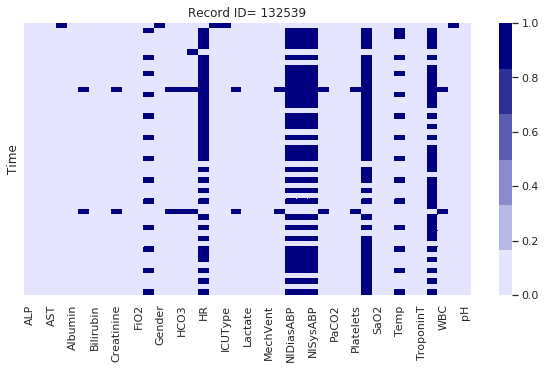

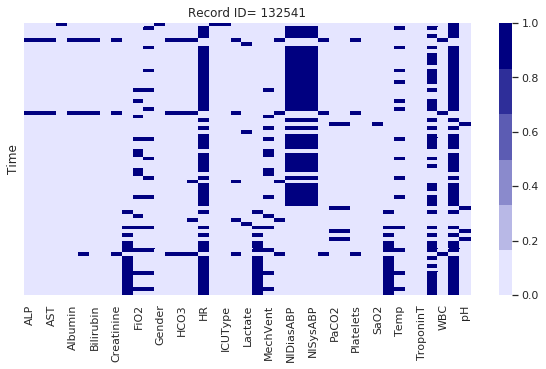

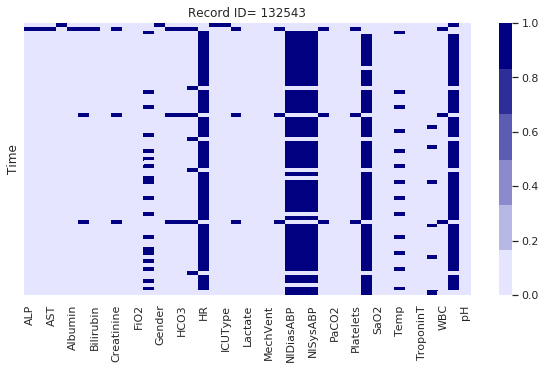

In [24]:
# # 畫出數個病人的資料空值熱圖
# # 淺色代表該處為空值，深色代表該處有資料
# recordIDs=np.array(train_x.index.levels[0])
# for idx in recordIDs[:3]:
#     fig,ax=plt.subplots(figsize=(10,5))
#     ax.set_title("Record ID= "+str(idx))
#     cmap=sns.light_palette("navy", reverse=False)
#     sns.heatmap(train_x.loc[idx].notnull(),yticklabels=False,cmap=cmap,ax=ax)
#     plt.show()
    

# 畫出數個病人的資料空值熱圖
# 淺色代表該處為空值，深色代表該處有資料
for idx in record_ids_train[0:3]:
    fig,ax=plt.subplots(figsize=(10,5))
    ax.set_title("Record ID= "+str(idx))
    cmap=sns.light_palette("navy", reverse=False)
    sns.heatmap(train_x.loc[idx].notnull(),yticklabels=False,cmap=cmap,ax=ax)
    plt.show()

In [25]:
assert (train_x.columns == test_x.columns).sum() == train_x.shape[1]
assert (val_x.columns == test_x.columns).sum() == val_x.shape[1]

cols_to_norm=train_x.columns

In [26]:
for col in cols_to_norm:
    mean = train_x[col].mean()
    std = train_x[col].std()
    train_x[col] = ( train_x[col]-mean )/ std
    val_x[col] = ( val_x[col]-mean  )/ std
    test_x[col] = ( test_x[col]-mean  )/ std

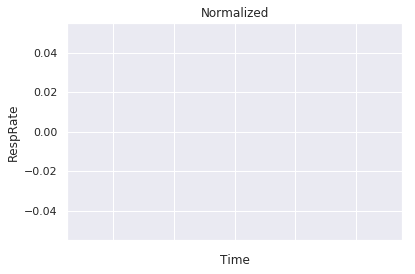

In [28]:
# 看某病患的呼吸率資訊(空值填補前)

recordID=train_x.iloc[0].name[0] #train data內第一個病患的recordID

train_x.loc[recordID,"RespRate"].plot()
plt.title("Normalized")
plt.ylabel("RespRate")
plt.xlabel("Time")
plt.show()

#### 將空值做填補

In [29]:
cols_to_fill=train_x.columns
for col in cols_to_fill:
    train_x[col] = train_x.groupby(level=0)[col].ffill()
    test_x[col] = test_x.groupby(level=0)[col].ffill()
    val_x[col] = val_x.groupby(level=0)[col].ffill()
# 填補空值
train_x.fillna(value=0, inplace=True)
test_x.fillna(value=0, inplace=True)
val_x.fillna(value=0, inplace=True)

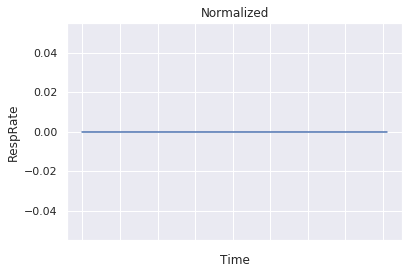

In [30]:
# 看某病患的呼吸率資訊(空值填補後)

train_x.loc[recordID,"RespRate"].plot()
plt.title("Normalized")
plt.ylabel("RespRate")
plt.xlabel("Time")
plt.show()

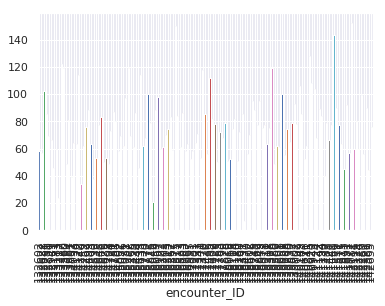

In [31]:
# 略為了解一下，前一萬個病人，他們的時序列長度為何 (x軸為病人ID, y軸為時間點)
train_x.head(10000).groupby(level=0).size().plot(kind="bar")

In [32]:
import keras
from keras.preprocessing import sequence

In [33]:
def data_list_creator(df):
    
    data_lst=[]
    groups=df.groupby(level=0)
    for name,group in groups:
        data_lst.append( group.values )
    return data_lst

In [41]:
train_x_list = data_list_creator( train_x )
train_y_list = data_list_creator( train_y )

test_x_list = data_list_creator( test_x )
test_y_list = data_list_creator( test_y )

val_x_list = data_list_creator( val_x )
val_y_list = data_list_creator( val_y )


[array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([1]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([1]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([1]),
 array([0]),
 array([0]),
 array([1]),
 array([1]),
 array([0]),
 array([0]),
 array([1]),
 array([0]),
 array([1]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([1]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([1]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),

In [35]:
# 由於Tensor需要固定大小，我們將固定時間序列長度=150 (也就是說，若時序長度不滿150, 則補0，超過，則截斷)

train_x_new = sequence.pad_sequences(train_x_list, dtype='float32', maxlen=150, padding='post', truncating='post')
test_x_new = sequence.pad_sequences(test_x_list, dtype='float32', maxlen=150, padding='post', truncating='post')
val_x_new = sequence.pad_sequences(val_x_list, dtype='float32', maxlen=150, padding='post', truncating='post')

In [36]:
print( train_x_new.shape )
print( train_y.shape )

(2800, 150, 41)
(2800,)


## 2. 建立模型

In [37]:
from keras.layers import LSTM, Dense, Input, TimeDistributed, Masking
from keras.models import Model,Sequential
from keras.optimizers import RMSprop

timesteps=150
data_dim=train_x.shape[-1]


# 建立模型
model=Sequential()
# 加入Masking。Masking的用意是：若某時刻資料皆為0,則機器不應去學習該時刻的資料。
# 該時刻的資料應以Masking(遮罩)來處理，使得該時刻的資料不會被納入訓練。
model.add(Masking(mask_value=0., input_shape=(timesteps, data_dim)))
# 加第一層LSTM
lstm_kwargs = {'dropout': 0.5, 'recurrent_dropout': 0.5, 'return_sequences': True}
model.add( LSTM(256, **lstm_kwargs)
         )
# 加第二層LSTM
lstm_kwargs = {'dropout': 0.5, 'recurrent_dropout': 0.5, 'return_sequences': False}
model.add( LSTM(64, **lstm_kwargs)
         )
# 加入Dense，用以輸出生還機率
model.add( Dense(1, activation='sigmoid')
         )
# 編譯模型
optimizer = RMSprop(lr=0.003)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=["accuracy"])

# 印出模型摘要
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_1 (Masking)          (None, 150, 41)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 150, 256)          305152    
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                82176     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 387,393
Trainable params: 387,393
Non-trainable params: 0
_________________________________________________________________


## 3. 訓練模型

Train on 2800 samples, validate on 600 samples
Epoch 1/15
2800/2800 [==============================] - 71s 25ms/step - loss: 0.3996 - acc: 0.8393 - val_loss: 0.3405 - val_acc: 0.8767
Epoch 2/15
2800/2800 [==============================] - 58s 21ms/step - loss: 0.3577 - acc: 0.8664 - val_loss: 0.3124 - val_acc: 0.8800
Epoch 3/15
2800/2800 [==============================] - 78s 28ms/step - loss: 0.3659 - acc: 0.8604 - val_loss: 0.3190 - val_acc: 0.8733
Epoch 4/15
2800/2800 [==============================] - 80s 28ms/step - loss: 0.3504 - acc: 0.8650 - val_loss: 0.3070 - val_acc: 0.8767
Epoch 5/15
2800/2800 [==============================] - 79s 28ms/step - loss: 0.3455 - acc: 0.8668 - val_loss: 0.3019 - val_acc: 0.8717
Epoch 6/15
2800/2800 [==============================] - 80s 28ms/step - loss: 0.3433 - acc: 0.8664 - val_loss: 0.3118 - val_acc: 0.8767
Epoch 7/15
2800/2800 [==============================] - 80s 29ms/step - loss: 0.3335 - acc: 0.8696 - val_loss: 0.2953 - val_acc: 0.8800
E

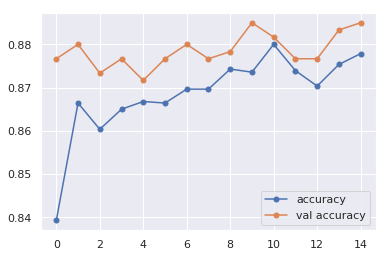

In [38]:
history = model.fit(train_x_new, train_y, batch_size=64, epochs=15,
                    verbose=1,validation_data=[val_x_new, val_y])

# 畫出模型訓練情形。
plt.plot(history.history['acc'],ms=5,marker='o',label='accuracy')
plt.plot(history.history['val_acc'],ms=5,marker='o',label='val accuracy')
plt.legend()
plt.show()

In [39]:
# 拿建好的模型於test data做出預測
preds = model.predict(test_x_new)
preds.shape

(600, 1)

## 4. 畫出ROC指標, 驗證模型好壞

https://en.wikipedia.org/wiki/Receiver_operating_characteristic

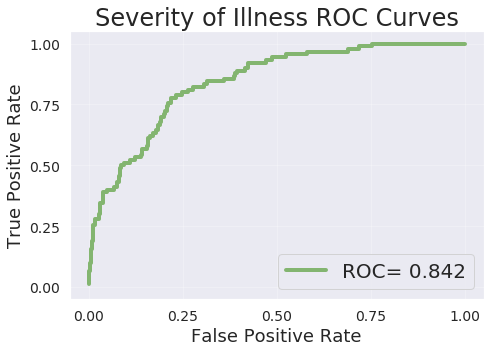

In [40]:
from sklearn.metrics import roc_curve, auc

# get 0/1 binary lable for each patient encounter
label = test_y

# get the last prediction in [0,1] for the patient
prediction = preds

# compute ROC curve for predictions
rnn_roc = roc_curve(label,prediction)

# compute the area under the curve of prediction ROC
rnn_auc = auc(rnn_roc[0], rnn_roc[1])

# plot rocs & display AUCs
plt.figure(figsize=(7, 5))
line_kwargs = {'linewidth': 4, 'alpha': 0.8}
plt.plot(rnn_roc[0], rnn_roc[1], label="ROC= %0.3f" % rnn_auc, color='#6AA84F', **line_kwargs)
plt.legend(loc='lower right', fontsize=20)
plt.xlim((-0.05, 1.05))
plt.ylim((-0.05, 1.05))
plt.xticks([0, 0.25, 0.5, 0.75, 1.0], fontsize=14)
plt.yticks([0, 0.25, 0.5, 0.75, 1.0], fontsize=14)
plt.xlabel("False Positive Rate", fontsize=18)
plt.ylabel("True Positive Rate", fontsize=18)
plt.title("Severity of Illness ROC Curves", fontsize=24)
plt.grid(alpha=0.25)
plt.tight_layout()